<p style="text-align:center;">
    <img src="https://miro.medium.com/v2/resize:fit:1024/1*idLhmtcMdWeN-UMGR0ROjQ.png"
         alt="DigitalFuturesLogo"
         style="width: 50%; height: auto; margin-right: 10px;" />
</p>

# The Movie Database
### _An Exploratory Data Analysis_

#### **Key Findings:**
* Animation leads the industry in both revenue and popularity.
* Higher budget films are more volatile in revenue.
* Commercial Success & Popularity: There's more to the story. 

In [269]:
# import modules & dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

df = pd.read_csv('/Users/mishabelsky/Downloads/TMDB_movies.csv')

#create budget/revenue columns by million (for readability)
df['budget_million$'] = df['budget'] / 1e6
df['revenue_million$'] = df['revenue'] / 1e6

#save original df
df_og = df.copy()

#filter out 0s from budget / revenue / avg vote / total votes (to avoid skews in aggregates)
df = df[(df['budget_million$'] > 0) & (df['revenue_million$'] > 0) & (df['vote_average'] > 0) & (df['vote_count'] > 0)]

def extract(x):
    ''' Function to extract genres for each datapoint. '''
    x = ast.literal_eval(x) ## Transform '['name', 'id']' back into ['name', 'id']
    Listo = [] ## Empty list to store the genres
    
    # Iterate through each dictionary
    for item in x: ## iterate for each dictionary in our list
        Listo.append(item['name']) ## Grab the 'name' key for each dictionary
        
    # Return the List
    return Listo

# apply the function to genres and others
df['genre_names'] = df['genres'].apply(extract)
df['production_companies'] = df['production_companies'].apply(extract)
df['production_countries'] = df['production_countries'].apply(extract)

# drop unnecessary uncolumns and reorder them
df = df.drop(columns=['genres','keywords', 'overview', 'tagline', 'homepage', 'budget', 'revenue', 'status', 'original_title'])
df = df[['title', 'release_date', 'genre_names', 'revenue_million$', 'budget_million$', 'vote_average', 'vote_count', 'popularity', 'id', 'original_language', 'production_companies', 'production_countries', 'runtime', 'spoken_languages']]
# df.head()


### First, let's look at how the average revenue and budget varies between genres. 

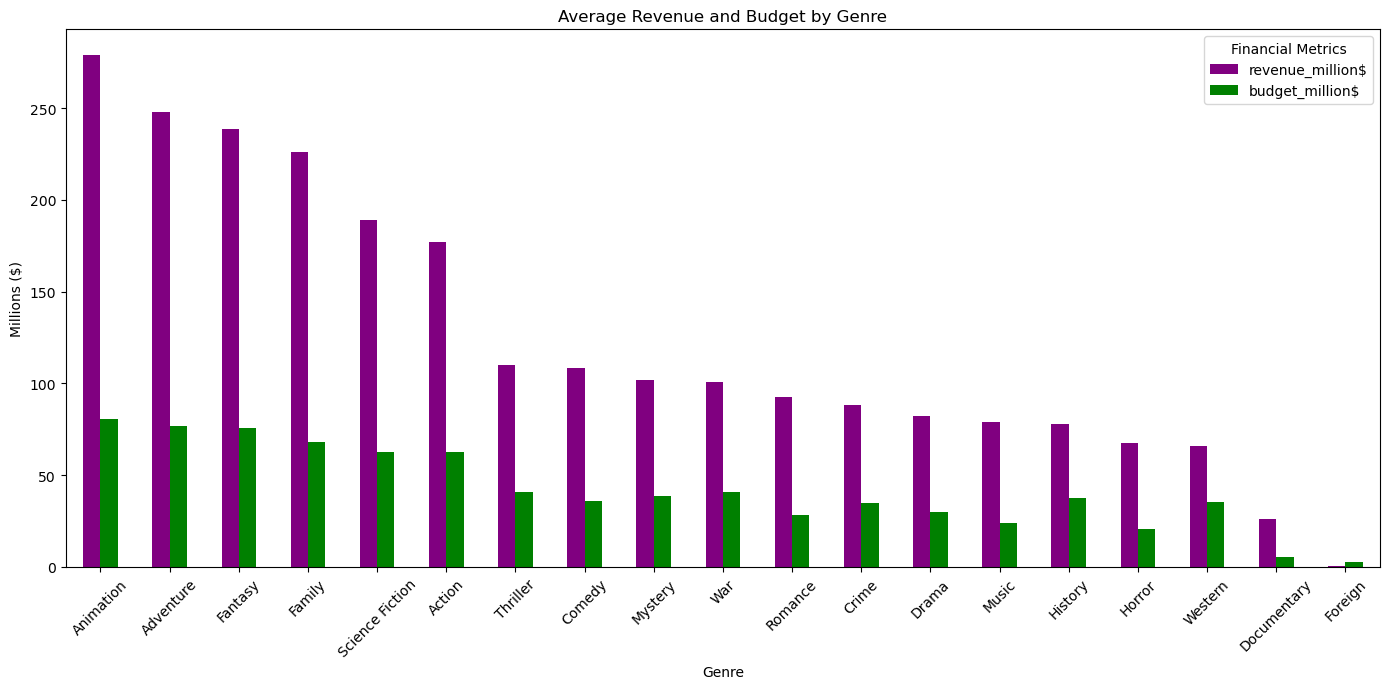

In [279]:
# seperate genre_names contents [lists] into seperate rows for each value
df_exploded = df_filtered.explode('genre_names')

# calculate average revenue and budget by genre
genre_financials = df_exploded.groupby('genre_names')[['revenue_million$', 'budget_million$']].mean()

# create a double bar plot
fig, ax = plt.subplots(figsize=(14, 7))
# sort financials dataframe by revenue descending and plot
genre_financials.sort_values(by='revenue_million$', ascending=False).plot(kind='bar',  ax=ax, color=['purple', 'green'])

# set labels, add legend,
ax.set_title('Average Revenue and Budget by Genre')
ax.set_xlabel('Genre')
ax.set_ylabel('Millions ($)')
plt.xticks(rotation=45)
plt.legend(title='Financial Metrics')
plt.tight_layout()
plt.show()

### The variance in revenue vastly outweighs the variance in budget. 
### This suggests that there are more and less 'popular' genres (as measured by revenue, controlling for budget).

### Next, let's look at how revenue generation varies according to budget.

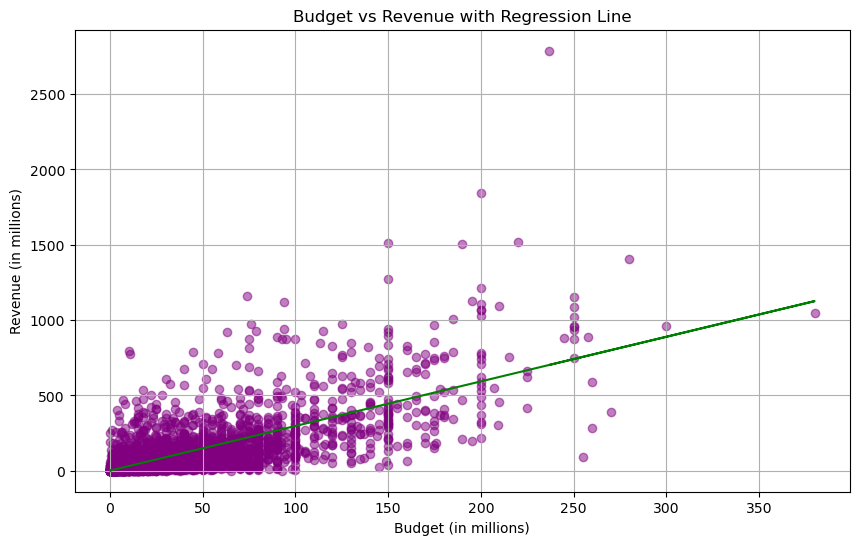

In [352]:
# calculate the line of best fit using m, b = .polyfit()
x = df['budget_million$']
y = df['revenue_million$']
m, b = np.polyfit(x, y, 1)

# scatter plot, set points to 0.5 transparency 
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, color='purple') 
# add regression line
plt.plot(x, m*x + b, color='green')  

#formatting
plt.title('Budget vs Revenue with Regression Line')
plt.xlabel('Budget (in millions)')
plt.ylabel('Revenue (in millions)')
plt.grid(True)
plt.show()

- #### As a very general trend, it appears that films with higher budgets are more volatile with respect to revenue generation.
- #### From a business perspective, this makes big budget films a more risky investment, which is no great revelation. 
- #### This greater level of risk would help explain why studios generally tend to produce films with lower budgets, as illustrated below.

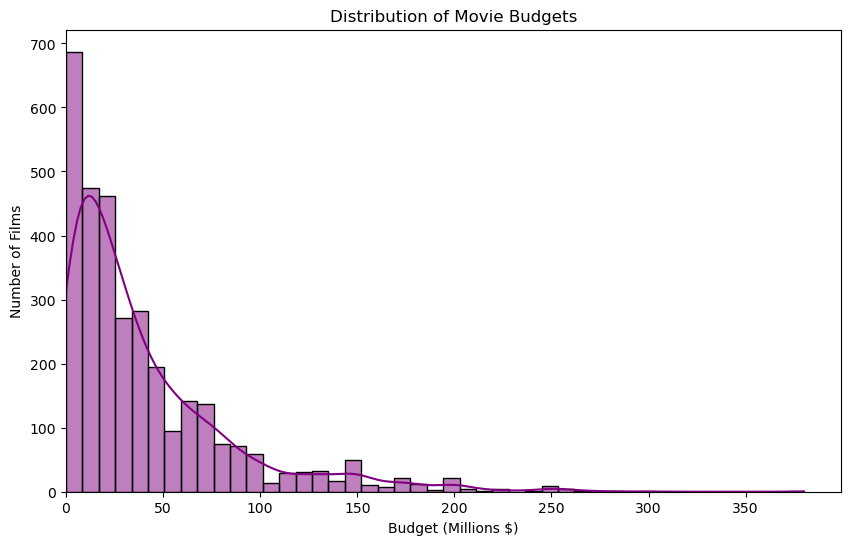

In [360]:
# create histogram, bucketise so roughly aligns with 10m intervals for readability
plt.figure(figsize=(10, 6))
sns.histplot(df['budget_million$'], bins=45, kde=True, color='purple')
plt.title('Distribution of Movie Budgets')
plt.xlabel('Budget (Millions $)')
plt.ylabel('Number of Films')
plt.xlim(0)
plt.show()

- #### Put simply, high budget films **must** generate significant revenue in order to turn a profit. 
- #### Even if these films generate a relatively high revenue, and are not poorly received, they can still incur heavy losses as illustrated by the **Top 10 Biggest Losers** (_below_). 

In [396]:
# create column with calculated profit (negative profit = loss)
df['profit_million$'] = df['revenue_million$'] - df['budget_million$']

# find the biggest loss-making movies by sorting by profit
biggest_losers = df.sort_values(by='profit_million$', ascending=True)

# display the top 10 biggest loss-making movies
biggest_losers[['title', 'profit_million$','budget_million$', 'revenue_million$', 'popularity', 'vote_count', 'vote_average', 'genre_names']].head(10)

,title,profit_million$,budget_million$,revenue_million$,popularity,vote_count,vote_average,genre_names
13,The Lone Ranger,-165.710090,255.00,89.289910,49.046956,2311,5.9,"[Action, Adventure, Western]"
338,The Alamo,-119.180039,145.00,25.819961,10.660441,106,5.8,"[Western, History, War]"
141,Mars Needs Moms,-111.007242,150.00,38.992758,12.362599,199,5.5,"[Adventure, Animation, Family]"
208,The 13th Warrior,-98.301101,160.00,61.698899,27.220157,510,6.4,"[Adventure, Fantasy, Action]"
311,The Adventures of Pluto Nash,-92.896027,100.00,7.103973,12.092241,142,4.4,"[Action, Comedy, Science Fiction]"
2638,Metropolis,-91.969578,92.62,0.650422,32.351527,657,8.0,"[Drama, Science Fiction]"
340,Cutthroat Island,-87.982678,98.00,10.017322,7.029308,136,5.7,"[Action, Adventure]"
142,Flushed Away,-84.540684,149.00,64.459316,22.550135,874,6.0,"[Adventure, Animation, Comedy, Family]"
192,Australia,-80.445998,130.00,49.554002,28.840997,694,6.3,[Drama]
272,Town & Country,-79.627709,90.00,10.372291,1.004579,16,3.7,"[Comedy, Romance]"


#### The Lone Ranger, despite being the biggest loser, generated more revenue than any other in the top 10, and received a respectable average rating of 5.9.

## **'The Lone Ranger': A Lone Failure?**

<p style="text-align:center;">
    <img src="https://www.publicdomainpictures.net/pictures/170000/nahled/lone-ranger.jpg"
         style="width: 10%; height: auto; margin-right: 3px;" />
</p>


Of the Top 10 Biggest Losers, half are period pieces:
- The Lone Ranger
- The Alamo
- The 13th Warrior
- Cutthroat Island
- Australia

Whilst three are comedies:
- Flushed Away
- The Adventures of Pluto Nash
- Mars Needs Moms(classed as a comedy [elsewhere](https://en.wikipedia.org/wiki/Mars_Needs_Moms))

The remaining film, Metropolis, was released in 1927, which may explain its outlier status. [Further research](https://cinephiliabeyond.org/metropolis/) reveals that the film's long runtime and [alleged 'communist' subtext](https://newrepublic.com/article/76533/metropolis-classic-movies#:~:text=Its%20parable%20of%20crowds%20and,and%20follow%20us%20on%20Twitter.) led to the film being pulled and recut by German distributors. 

#### Interestingly, whilst each Biggest Loser tends to be relatively unpopular, their respective genres are broadly unpopular relative to others. 

### Let's now look at Popularity by Genre _(as measured by TMDB's Popularity Metric and average rating)_

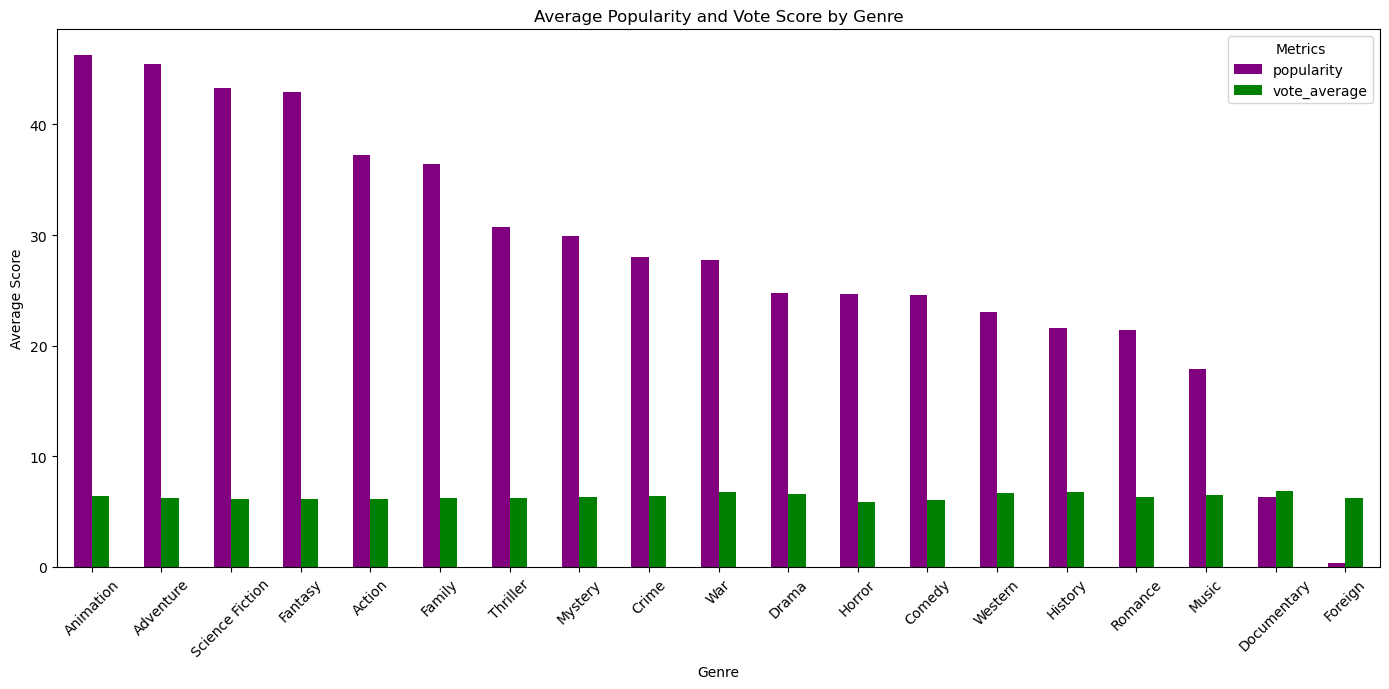

In [162]:
genre_averages = df_exploded.groupby('genre_names')[['popularity', 'vote_average']].mean()

import matplotlib.pyplot as plt

# Create a double bar plot
fig, ax = plt.subplots(figsize=(14, 7))
genre_averages.sort_values(by='popularity', ascending=False).plot(kind='bar', ax=ax, color=['purple', 'green'])
ax.set_title('Average Popularity and Vote Score by Genre')
ax.set_xlabel('Genre')
ax.set_ylabel('Average Score')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

#### As we can see, Comedies, Westerns, and Historical films are similarly unpopular relative to other genres. 
#### So it seems Lone Ranger is not a lone failure; rather, it shares some features (unpopular genre, big budget) with its counterparts.

That's not to say these genres _can't_ perform well. 

In fact, Titanic has the 2nd highest revenue of all time, and 9th most profitable, despite being a historical romantic drama.

If the biggest losers tend to belong to relatively unpopular genres, we might expect the biggest winners -- the most profitable films -- to be from more popular genres. 

#### **Hypothesis:** The most profitable films belong to the most popular genres. 

#### So let's now test our hypothesis, and look at the Top 10 Biggest Winners and the genres they belong to. 

In [332]:
# create column calculating profit
df_filtered['profit_million$'] = df_filtered['revenue_million$'] - df_filtered['budget_million$']

# sort by profit, order by profit ascending
biggest_losses = df_filtered.sort_values(by='profit_million$', ascending=False)

# display the Top 10 Biggest Winners
biggest_losses[['title', 'profit_million$', 'genre_names', 'budget_million$', 'revenue_million$', 'popularity', 'vote_count', 'vote_average']].head(10)

,title,profit_million$,genre_names,budget_million$,revenue_million$,popularity,vote_count,vote_average
0,Avatar,2550.965087,"[Action, Adventure, Fantasy, Science Fiction]",237.0,2787.965087,150.437577,11800,7.2
25,Titanic,1645.034188,"[Drama, Romance, Thriller]",200.0,1845.034188,100.025899,7562,7.5
28,Jurassic World,1363.528810,"[Action, Adventure, Science Fiction, Thriller]",150.0,1513.528810,418.708552,8662,6.5
44,Furious 7,1316.249360,[Action],190.0,1506.249360,102.322217,4176,7.3
16,The Avengers,1299.557910,"[Science Fiction, Action, Adventure]",220.0,1519.557910,144.448633,11776,7.4
7,Avengers: Age of Ultron,1125.403694,"[Action, Adventure, Science Fiction]",280.0,1405.403694,134.279229,6767,7.3
124,Frozen,1124.219009,"[Animation, Adventure, Family]",150.0,1274.219009,165.125366,5295,7.3
546,Minions,1082.730962,"[Family, Animation, Adventure, Comedy]",74.0,1156.730962,875.581305,4571,6.4
329,The Lord of the Rings: The Return of the King,1024.888979,"[Adventure, Fantasy, Action]",94.0,1118.888979,123.630332,8064,8.1
31,Iron Man 3,1015.439994,"[Action, Adventure, Science Fiction]",200.0,1215.439994,77.682080,8806,6.8


**Our hypothesis is confirmed**: of the top 10 most profitable films, all (except Titanic) belong to one of the top 5 most popular genres:
1. Animation
2. Adventure
3. Science Fiction
4. Fantasy
5. Action

and 8/10 belong to more than one. 

It should also be noted, 
- All are relatively _high-budget_ (above $70m, see Distribution of Movie Budgets, above)
- All _except Titanic_ belong to a franchise and were released in the 21st century

This makes Titanic a significant outlier. 

# THE MINIONS

<p style="text-align:center;">
    <img src="https://media.istockphoto.com/id/474935824/photo/minions-toy-isolated-on-white-background.jpg?s=612x612&w=0&k=20&c=Hnb9mpoc6-_669mnUHGdH6_sOziBFTdvtzV0efW64IA="
         style="width: 20%; height: auto; margin-right: 5px;" />
</p>


Another interesting outlier is Minions, which has: 
- Less than **half the budget** of any other film in the top 10 (by revenue).
- The **lowest average rating**, and the second lowest number of ratings, amongst the top 10 most profitable films.
- Yet on TMBD's **popularity** metric, it scores more than **double** any other film in the top 10 (both profit and revenue).

So on first glance, it seems Minions' success is due to its extraordinary popularity. But how should we understand this popularity? 

Intuitively, we might think the most popular films in a database are those with either the highest rating (average vote), the highest engagement (vote count), or some combination of the two. 

## Let's finally look at the Minion's Popularity ...
#### ...and see whether it corresponds to either the quantity, or the quality of ratings.
##### _below are films displayed by Popularity (y axis) against Total Votes (x-axis), coloured by their average rating_
##### Minions is the most conspicuous outlier, being of highest popularity score (876, top of the graph), yet unexceptional in its vote count (4571) and average rating (6.4). 

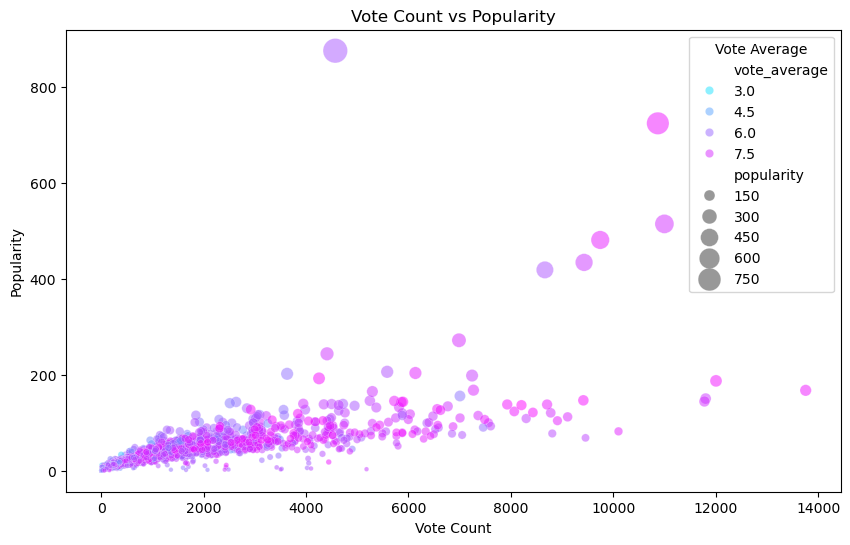

In [394]:
# create scatterplot 
plt.figure(figsize=(10, 6))
# display vote count on x-axis, popularity on y-axis, 
# colour by average vote, group point size by popularity, set point colour to semi-transparncy, set big point size range 
sns.scatterplot(x='vote_count', y='popularity', hue='vote_average', size='popularity',
                data=df, palette='cool', sizes=(10, 310), alpha=0.5)
# set labels, add legend
plt.title('Vote Count vs Popularity')
plt.xlabel('Vote Count')
plt.ylabel('Popularity')
plt.legend(title='Vote Average')
plt.show()

### Minions' pre-eminent popularity, it appears, does not correspond to a particularly high average rating, nor a large volume of ratings.
#### So what makes it so popular?

According to [TMDB](https://developer.themoviedb.org/docs/popularity-and-trending), the popularity metric weighs: 

- Number of votes for the day
- Number of views for the day
- Number of users who marked it as a "favourite" for the day
- Number of users who added it to their "watchlist" for the day
- Release date
- Number of total votes
- Previous days score

Minions' outlier status suggests that popularity, and relatedly commercial success, is not entirely determined by conventional metrics such as:  
- how much is spent on a film 
- how much people _on average_ like a film.
- how many people provide ratings for a film.

Perhaps younger audiences are underrepresented in the data. 

Perhaps these conventional metrics don't account for the influence of online engagement on commercial success, as evidenced by the recent sequel - Minions: The Rise of Gru (2022) - which became a [viral phenomenon](https://knowyourmeme.com/editorials/guides/why-are-people-wearing-suits-to-minions-the-rise-of-gru-and-what-are-all-the-memes-about), garnering significant media attention and box-office revenue as a result. 


# Key Takeaways:
- #### A film's commercial success and the popularity of its genre(s) are correlated, and this correlation is most salient at the extreme ends of the spectrum (i.e. the biggest winners and biggest losers).
- #### Animation leads the pack, both in revenue and popularity.
- #### Period pieces (historical epics, westerns) and comedies account for most of the biggest commercial flops.
- #### Big budget films are both the most and least profitable; they are the _lame ducks_ and the _golden geese_. This volatility makes big budget productions a more risky investment for a studio.
- #### Big budget productions are both rare and largely reserved for franchises with existing audiences, which supports the reported ['risk-aversion'](https://www.projectedstatic.com/p/risk-aversion-in-hollywood-the-descent?utm_campaign=post&utm_medium=web) pervading Hollywood. 
- #### Nevertheless, outliers such as Minions and Titanic suggest that the conventional predictors of profitability -- genre popularity, production budget, and critical success -- are not the be-all and end-all for commercial success.